In [50]:
import sys
import os
import random
import numpy as np
import datetime
import copy
import shutil

import torch
import torch.nn as nn
from torch import autograd
from tqdm.auto import tqdm
from torchvision import transforms
# from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torchvision.datasets as dset # all datasets available in torch vision. not sure if needed here
import torchvision.utils as vutils # draw bounding box, segmantation mask, keypoints. convert to rgb, make grid, save_image
import torch.optim as optim # optimizer for example optim.Adam([var1, var2], lr=0.0001)

import optuna
from optuna.trial import TrialState
import mlflow

# data distributed parallelization DDP
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group

import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!
import matplotlib.animation as animation
from IPython.display import HTML # to embed html in the Ipython output

sys.path.append("../src/utils/")
sys.path.append("../src/models/")
from Generator import OptGen
from Discriminator import OptDis
from utils import normalizeRGB
from utils import weights_init, single_conv, conv_grid_search, conv_path_search
from OptimisationFunctions import suggest_hyperparameters, trainModel, test, objective, gradient_penalty

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Set the parameters

In [3]:
cadastralRoot = '../../cadastralExportRGB' # Root directory for cadastral images
workers = 2 # Number of workers for dataloader
batch_size = 64 # Batch size during training
image_size = 64 # Spatial size of training images. All images will be resized to this
nc = 3 # Number of channels in the training images. For color images this is 3
nz = 100 # Size of z latent vector (i.e. size of generator input)
ngf = 64 # Size of feature maps in generator
ndf = 64 # Size of feature maps in discriminator
num_epochs = 500 # Number of training epochs
lr = 0.0002 # Learning rate for optimizers
beta1 = 0.5 # Beta1 hyperparam for Adam optimizers
lambda_gradient_penality = 0.2 # to adjust the Wasserstein distance with interpolation between real and fake data
ngpu = torch.cuda.device_count() # Number of GPUs available. Use 0 for CPU mode.
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
threshold = 0.75 # for labeling buildings, roads and the rest in cadastral images

## 1.1 Utility Functions

In [4]:
def generate_random_labels(batch_size: int, labels_size: int):
    
    """
    this function generates a flat tensor with length labels_size * batch_size,
    so that the sum of each labels per batch equals one 
    """
    
    labels = [] # torch.empty(size = labels_size * batch_size) #np.empty(labels_size * batch_size) # torch.zeros(labels_size * batch_size)
    for batch in range(batch_size):
        new_labels = [a for a in np.random.dirichlet(np.ones(labels_size), size=1)]
        labels.append([el for el in new_labels])
    labels = torch.tensor(labels).view(-1)
    return labels        

In [5]:
s = generate_random_labels(batch_size=batch_size, labels_size=3)
s.size()

/tmp/ipykernel_2143826/2953388218.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  labels = torch.tensor(labels).view(-1)


torch.Size([192])

# 2. Load Dataset

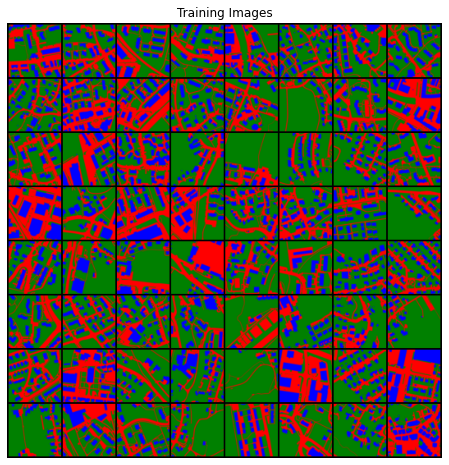

In [6]:
# We can use an image folder dataset the way we have it setup
if os.path.exists(cadastralRoot + '/.ipynb_checkpoints'):
    shutil.rmtree(cadastralRoot + '/.ipynb_checkpoints')

Cad_dataset = dset.ImageFolder(root=cadastralRoot,
                           transform=transforms.Compose([
                               transforms.CenterCrop(image_size * 12),
                               transforms.Resize(image_size),
                               # transforms.RandomCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
Cad_dataloader = torch.utils.data.DataLoader(Cad_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Plot some training images
Cad_real_batch = next(iter(Cad_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(Cad_real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)));

In [7]:
Cad_dataset

Dataset ImageFolder
    Number of datapoints: 313
    Root location: ../../cadastralExportRGB
    StandardTransform
Transform: Compose(
               CenterCrop(size=(768, 768))
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

# 3. Generator for Conditional GAN

In [65]:
# 5. Generator Class
class CondGen(nn.Module):
    def __init__(self, nz:int, num_conv_layers: int, drop_conv2: float, labels_numb: int):
        """
        This is the generator class for conditional GAN
        The input params are: 
            nz: dimension of the input noise z
            num_conv_layers: number of convolutional layers, between 3 and 6
            drop_conv2: probabiltity of the dropout for the dropout layer
            labels_numb: number of labels for the conditional distributions
        The output is a batch of images with 3 channels and resolution 64x64
        
        """
        super(CondGen, self).__init__()
        self.ngpu = torch.cuda.device_count()
        self.device = torch.device("cuda:0" if (torch.cuda.is_available() and self.ngpu > 0) else "cpu")
        self.drop_conv2 = drop_conv2
        self.nz = nz
        self.labels_numb = labels_numb
        self.num_filters = [3] 
        self.num_filters.extend([2**(i+6) for i in range(num_conv_layers-1)])
        self.output_size = 64 # resolution of the generated image
        self.num_conv_layers = num_conv_layers
        self.strides = []
        self.paddings = []
        self.kernelSizes = []
        self.out_size = []
        if self.num_conv_layers == 3:
            # solution 3: {'ins': [64, 22.0, 7.0], 'outs': [22.0, 7.0, 1.0], 'kernel_sizes': [3, 4, 7], 'paddings': [1, 0, 0], 'strides': [3, 3, 3]}
            s3, c3 = conv_path_search(64, kernel_sizes = [3,4,5,7], strides = list(range(1,4)), paddings = [0,1], convs = 3)
            solution = s3[-1] 
            self.strides = solution['strides']
            self.paddings = solution['paddings']
            self.kernelSizes = solution['kernel_sizes']
        if self.num_conv_layers == 4:
            # solution 2: {'ins': [64, 31.0, 14.0, 4.0], 'outs': [31.0, 14.0, 4.0, 1.0], 'kernel_sizes': [4, 5, 5, 4], 'paddings': [0, 0, 0, 0], 'strides': [2, 2, 3, 3]}
            s4, c4 = conv_path_search(64, kernel_sizes = [3,4,5], strides = list(range(2,4)), paddings = [0], convs = 4)
            solution = s4[-1] 
            self.strides = solution['strides']
            self.paddings = solution['paddings']
            self.kernelSizes = solution['kernel_sizes']
        # same scheme as for DNet, but inverted
        self.num_filters.reverse()
        self.strides.reverse()
        self.paddings.reverse()
        self.kernelSizes.reverse()
        
        ### Generator Architecture
        self.main = nn.Sequential(
            # input is Z, going into a convolution with dimensions c=nz + batch_size * labels_numb, h=1, w=1
            # output size: (2**6) x 4 x 4 O=(I-1)*s+k-2p
            nn.ConvTranspose2d(in_channels=self.nz + self.labels_numb, #deconvolution!
                               out_channels=self.num_filters[0], #ngf * 8, 
                               kernel_size=self.kernelSizes[0], 
                               stride=self.strides[0], 
                               padding=self.paddings[0], 
                               bias=False), # (1-1)*1+4-2*0=4
            nn.BatchNorm2d(self.num_filters[0]),
            nn.ReLU(True)
        )
        self.out_size.append([self.num_filters[0], (1-1)*self.strides[0]+self.kernelSizes[0]-2*self.paddings[0]])
        self.num_modules = 3
        for i in range(1, self.num_conv_layers):
            self.main.add_module(str(4*i-1)+": TransConv_"+str(i+1), nn.ConvTranspose2d(in_channels=self.num_filters[i-1],
                                                            out_channels=self.num_filters[i],
                                                            kernel_size=self.kernelSizes[i],
                                                            stride=self.strides[i],
                                                            padding=self.paddings[i],
                                                            bias=False))
            self.out_size.append([self.num_filters[i], (self.out_size[i-1][1]-1)*self.strides[i]+self.kernelSizes[i]-2*self.paddings[i]])
            self.num_modules += 1
            if i + 1 < self.num_conv_layers:
                self.main.add_module(str(4*i)+": DropOut_" + str(i+1), nn.Dropout2d(p=self.drop_conv2))
                self.main.add_module(str(1+4*i)+": BatchNorm_" + str(i+1), nn.BatchNorm2d(self.num_filters[i]))
                self.main.add_module(str(2+4*i)+": ReLU_" + str(i+1), nn.ReLU(True))
                self.num_modules += 3
            
        self.main.add_module(str(self.num_modules), nn.Softmax(dim=1)) #nn.Tanh()) # not sigmoid
    
    def forward(self, z: torch.Tensor, labels: torch.Tensor):
        '''here z and labels are combined in the input for main'''
        z = z.view(-1, self.nz, 1, 1).clone()
        c = labels.view(-1, 3, 1, 1).clone() # .to(self.device) #labels)
        x = torch.cat([z, c], 1)         
        x = self.main(x).clone() # clone, otherwise the variable it's modified in an inplace operation
        # print(f'output size before pre-processing: {x.size()}')
        # x = self.batch_to_class(x) # since apply_ is only implemented on CPU tensors
        return x #.to(device)

In [66]:
netG = CondGen(nz=nz, num_conv_layers=4, drop_conv2=0.5, labels_numb=3).to(device)
netG.apply(weights_init)
print(netG)

CondGen(
  (main): Sequential(
    (0): ConvTranspose2d(103, 256, kernel_size=(4, 4), stride=(3, 3), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3: TransConv_2): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(3, 3), bias=False)
    (4: DropOut_2): Dropout2d(p=0.5, inplace=False)
    (5: BatchNorm_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6: ReLU_2): ReLU(inplace=True)
    (7: TransConv_3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (8: DropOut_3): Dropout2d(p=0.5, inplace=False)
    (9: BatchNorm_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10: ReLU_3): ReLU(inplace=True)
    (11: TransConv_4): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (12): Softmax(dim=0)
  )
)


### 3.1 Post Processing

In [50]:
def pixel_to_class(values: torch.Tensor):
    '''
    returns the rgb class values of a certain pixel with the highest probability
    img: tensor with channels, pixel raws, pixel columns
    x, y: position of the selected pixel
    channel 1: buildings -> rgb (0, 0, 0) -> black
    channel 2: roads -> rgb (1, 1, 1) -> white
    channel 3: other -> rgb(0.4118, 0.4118, 0.4118) -> dimgray
    NOT DIFFERENTIABLE, THEREFORE NOT TRAINABLE AND NOT TO BE INCLUDED IN TRAINING
    '''
    l = values.max()
    ind = [i for i, j in enumerate(values) if j == l][0]
    # result = torch.tensor(device = self.device)
    if ind == 0:
        result = torch.tensor([0,0,0], device = device) # building  
    elif ind == 1:
        result = torch.tensor([1,1,1], device = device) # road
    elif ind == 2:
        result = torch.tensor([0.4118,0.4118,0.4118], device = device) # other
    return result

def img_to_class(img: torch.Tensor):
    '''
    postprocesses an image generated by a GNet
    '''
    view = img.view(-1, 3)
    res = torch.stack([pixel_to_class(x_i.to(device)) for x_i in torch.unbind(view, dim=0)], dim=0)
    res = res.reshape(64,64,3)
    res = res.permute(2,0,1)
    return res

def batch_to_class(batch: torch.Tensor):
    '''
    postprocess a batch of images generated by a GNet interpreting the probability to have a certain class
    '''
    res = torch.stack([
    img_to_class(x_i.to(device)) for i, x_i in enumerate(torch.unbind(batch, dim=0), 0)], dim=0) 
    return res

In [31]:
print(f'strides: {netG.strides}')
print(f'kernel sizes: {netG.kernelSizes}')
print(f'paddings: {netG.paddings}')
# transposed convolution i=(o - 1)s + k - 2p
inpt = 1
for i in range(4):
    output = (inpt - 1) * netG.strides[i] + netG.kernelSizes[i] - 2 * netG.paddings[i]
    print(f"Convolution {i+1}: ins: {inpt} | outs: {output} | kernel size {netG.kernelSizes[i]} | strides: {netG.strides[i]} | paddings: {netG.paddings[i]}")
    inpt = output

strides: [3, 3, 2, 2]
kernel sizes: [4, 5, 5, 4]
paddings: [0, 0, 0, 0]
Convolution 1: ins: 1 | outs: 4 | kernel size 4 | strides: 3 | paddings: 0
Convolution 2: ins: 4 | outs: 14 | kernel size 5 | strides: 3 | paddings: 0
Convolution 3: ins: 14 | outs: 31 | kernel size 5 | strides: 2 | paddings: 0
Convolution 4: ins: 31 | outs: 64 | kernel size 4 | strides: 2 | paddings: 0


In [11]:
z = torch.randn(64, nz, 1, 1, device=device)
l = torch.rand([64, 3], device = device)

In [12]:
%%time
# print(f'size for noise and labels: {x.size()}')
pred = netG.forward(z, l)

CPU times: user 1.15 s, sys: 1 s, total: 2.16 s
Wall time: 36.7 s


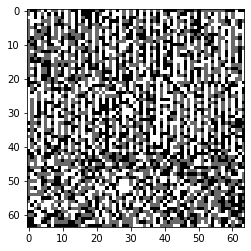

In [13]:
i = random.sample(range(batch_size), 1)[0]
plt.figure(figsize=(4,4))
img = pred[i]
plt.imshow(img_to_class(img).permute(1,2,0).cpu());

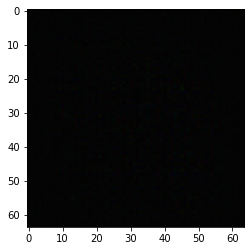

In [14]:
plt.imshow(pred[i].permute(1,2,0).cpu().detach());

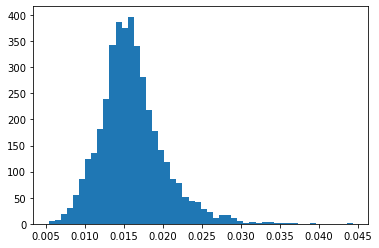

In [15]:
plt.hist(pred[i][0].detach().cpu().flatten().tolist(), bins = 50);

## 3.2 Post Processing Functions
not efficient, since the params are not learnable

In [ ]:
def regularize(self, x: float, threshold: float = 0.75):
        '''
        regularize the value of the input x to one of the three standard values 0, 1.5 and 3
        dimgray = 41.18%
        '''
        if x <= threshold:
            x = 0
        elif x >= 3 - threshold:
            x = 1
        else:
            x = 0.4118
        return x

def postprocess_cadastral(self, img: torch.Tensor, threshold: float = 0.75):
    '''
    postprocesses an image generated by a GNet
    '''
    values = img.sum(axis=0).apply_(lambda m: self.regularize(m, threshold = threshold))
    res = torch.cat([values, values, values])
    res = res.view(-1, 64, 64)
    return res

def postprocess_batch(self, batch: torch.Tensor, threshold: float = 0.75):
    '''
    postprocess a batch of images generated by a GNet
    '''
    res = torch.stack([
    self.postprocess_cadastral(x_i, threshold = threshold) for i, x_i in enumerate(torch.unbind(batch, dim=0), 0)], dim=0) 
    return res

## 3.3 Channel as probability to predict a class
this series of functions serve to interpret each channel as a class. If a certain value is reached, than the pixel receives the color of the class 

min f(x) = 0.006692850962281227
min f(x) = 0.9933071732521057


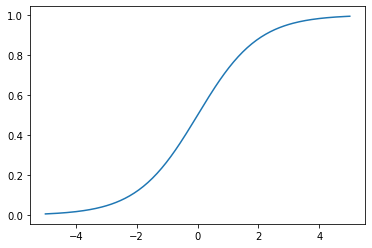

In [82]:
f = nn.Sigmoid()
x = torch.Tensor(np.linspace(-5,5, 200))
print(f'min f(x) = {f(x).min()}')
print(f'min f(x) = {f(x).max()}')
plt.plot(x, f(x));

we use softmax and not sigmoid, since softmax returns the probability for n classes

min f(x) = 2.2251263089856366e-06
min f(x) = 0.04901166632771492


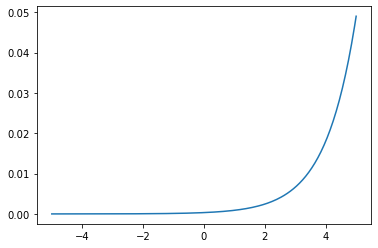

In [465]:
f = nn.Softmax(dim = 0)
x = torch.Tensor(np.linspace(-5,5, 200))
print(f'min f(x) = {f(x).min()}')
print(f'min f(x) = {f(x).max()}')
plt.plot(x, f(x));

### 3.2.1 Experiment 1
not efficient, two loops

In [44]:
def value_to_class(img: torch.Tensor, x:int, y:int):
    '''
    returns the rgb class values of a certain pixel with the highest probability
    img: tensor with channels, pixel raws, pixel columns
    x, y: position of the selected pixel
    channel 1: buildings -> rgb (0, 0, 0) -> black
    channel 2: roads -> rgb (1, 1, 1) -> white
    channel 3: other -> rgb(0.4118, 0.4118, 0.4118) -> dimgray
    '''
    values = [img[c][x][y] for c in range(img.size(0))]
    l = max(values)
    ind = [i for i, j in enumerate(values) if j == l][0]
    result = torch.Tensor()
    if ind == 0:
        result = torch.Tensor([0,0,0]) # building  
    elif ind == 1:
        result = torch.Tensor([1,1,1]) # road
    elif ind == 2:
        result = torch.Tensor([0.4118,0.4118,0.4118]) # other
    return result

def img_to_class(img: torch.Tensor):
    '''
    return the rgb values for the class for tensor with channels, pixel rows and pixel columns
    channel 1: buildings -> rgb (0, 0, 0) -> black
    channel 2: roads -> rgb (1, 1, 1) -> white
    channel 3: other -> rgb(0.4118, 0.4118, 0.4118) -> dimgray
    '''
    result = torch.Tensor()
    x_size = img.size(1)
    y_size = img.size(2)
    for x  in range(x_size):
        for y in range(y_size):
            result = torch.cat((result, value_to_class(img, x, y)), 0)
    result = torch.reshape(result, (x_size, y_size, 3))
    result = result.permute(2, 0, 1)
    return result

def batch_to_class(batch: torch.Tensor):
        '''
        postprocess a batch of images generated by a GNet interpreting the probability to have a certain class
        '''
        res = torch.stack([
        img_to_class(x_i) for i, x_i in enumerate(torch.unbind(batch, dim=0), 0)], dim=0) 
        return res

In [353]:
%%time
classes = batch_to_class(pred)

CPU times: user 37.9 s, sys: 0 ns, total: 37.9 s
Wall time: 42.2 s


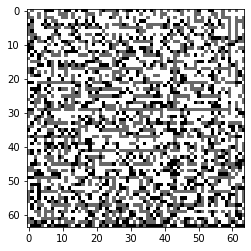

In [352]:
i = random.sample(range(batch_size), 1)[0]
plt.imshow(classes[i].detach().cpu().permute(1,2,0));

### 3.2.2 Experiment 2
more efficient, still cumbersome

In [458]:
def pixel_to_class(values: torch.Tensor):
    '''
    returns the rgb class values of a certain pixel with the highest probability
    img: tensor with channels, pixel raws, pixel columns
    x, y: position of the selected pixel
    channel 1: buildings -> rgb (0, 0, 0) -> black
    channel 2: roads -> rgb (1, 1, 1) -> white
    channel 3: other -> rgb(0.4118, 0.4118, 0.4118) -> dimgray
    '''
    l = values.max()
    ind = [i for i, j in enumerate(values) if j == l][0]
    result = torch.Tensor()
    if ind == 0:
        result = torch.Tensor([0,0,0]) # building  
    elif ind == 1:
        result = torch.Tensor([1,1,1]) # road
    elif ind == 2:
        result = torch.Tensor([0.4118,0.4118,0.4118]) # other
    return result

def img_to_class(img: torch.Tensor):
    '''
    postprocesses an image generated by a GNet
    '''
    view = img.view(-1, 3)
    res = torch.stack([pixel_to_class(x_i) for x_i in torch.unbind(p, dim=0)], dim=0)
    res = res.reshape(64,64,3)
    res = res.permute(2,0,1)
    return res

def batch_to_class(batch: torch.Tensor):
        '''
        postprocess a batch of images generated by a GNet interpreting the probability to have a certain class
        '''
        res = torch.stack([
        img_to_class(x_i) for i, x_i in enumerate(torch.unbind(batch, dim=0), 0)], dim=0) 
        return res

In [459]:
%%time
classes = batch_to_class(pred)

CPU times: user 24.7 s, sys: 10.4 ms, total: 24.7 s
Wall time: 27.4 s


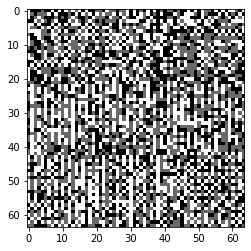

In [460]:
i = random.sample(range(batch_size), 1)[0]
plt.imshow(classes[i].detach().cpu().permute(1,2,0));

# 4. Conditional Discriminator

## 4.1 Embedding Conditions
The user gives three numbers for buildings, roads and the rest

In [16]:
# Coverts conditions into feature vectors
class Condition(nn.Module):
    def __init__(self, num_conv_layers: int = 3, alpha: float = 0.2):
        super().__init__()
        self.channels = 2**(num_conv_layers+6)

        # From label feature: 3 => 784
        self.fc = nn.Sequential(
            nn.Linear(3, self.channels),
            nn.BatchNorm1d(self.channels),
            nn.Linear(self.channels, 1),
            nn.LeakyReLU(alpha))
        
    def forward(self, labels: torch.Tensor):
        # NOT NEEDED HERE
        # # One-hot encode labels
        # x = F.one_hot(labels, num_classes=10)
        # 
        # # From Long to Float
        # x = x.float()
        
        # To feature vectors
        return self.fc(labels).view(-1,1,1,1)

In [17]:
labels = torch.rand([64, 3])
c = Condition(num_conv_layers = 4)
r = c.forward(labels)

In [18]:
c.forward(labels).size()

torch.Size([64, 1, 1, 1])

In [19]:
c = Condition(num_conv_layers = 3)
c.forward(labels)
print(f'outs with 3 convolutions: {c.forward(labels).size()}')
c = Condition(num_conv_layers = 4)
c.forward(labels)
print(f'outs with 4 convolutions: {c.forward(labels).size()}')

outs with 3 convolutions: torch.Size([64, 1, 1, 1])
outs with 4 convolutions: torch.Size([64, 1, 1, 1])


## 4.2 Function to convert values of a real cadastral image in labels for 
- buildings
- roads 
- rest

In [85]:
def regularize(x: float, threshold: float = 0.75):
    '''
    regularize the value of the input x to one of the three standard values 0, 1.5 and 3
    dimgray = 41.18%
    '''
    if x <= threshold:
        x = 0
    elif x >= 3 - threshold:
        x = 1
    else:
        x = 0.4118
    return x

def getCadastralLabels(img: torch.Tensor):
    '''
    get the labels for a single image
    '''
    img = normalizeRGB(img)
    intensity = img.sum(axis=0)
    intensity.apply_(regularize)
    black = torch.sum(intensity == 0)
    grey = torch.sum(intensity == 0.4118)
    white = torch.sum(intensity == 1)
    return torch.tensor([black, grey, white]).float()

def get_Batch_Cadastral_labels(batch: torch.Tensor):
    '''
    returns a batch of cadastral labels for real images
    '''
    # res = batch.apply_(getCadastralLabels)
    res = torch.stack([
            getCadastralLabels(x_i) for i, x_i in enumerate(torch.unbind(batch, dim=0), 0)], dim=0) 
    return res

In [173]:
values = img.sum(axis=0).apply_(lambda m: regularize(m, threshold))

In [190]:
i = random.sample(range(batch_size), 1)[0]
img = normalizeRGB(Cad_real_batch[0][i])

In [194]:
intensity = img.sum(axis=0)
intensity

tensor([[0.8353, 0.1059, 0.0000,  ..., 0.0000, 0.3176, 1.6588],
        [1.1882, 0.8588, 0.2000,  ..., 0.0000, 0.0824, 1.0118],
        [1.2353, 1.2235, 1.0471,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.8706, 1.2353, 1.2353,  ..., 1.2353, 1.2353, 1.2353],
        [1.2118, 1.2353, 1.2353,  ..., 1.2353, 1.2353, 1.2353],
        [1.2353, 1.2353, 1.2588,  ..., 1.2353, 1.2353, 1.2353]])

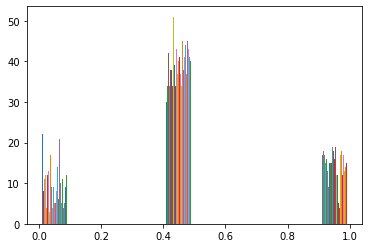

In [217]:
intensity = img.sum(axis=0)
intensity.apply_(regularize)
plt.hist(intensity);

In [222]:
print(f'white pixels: {torch.sum(intensity == 0)}')
print(f'grey pixels:  {torch.sum(intensity == 0.4118)}')
print(f'black pixels:  {torch.sum(intensity == 1)}')

white pixels: 614
grey pixels:  2548
black pixels:  934


In [250]:
getCadastralLabels(img)

tensor([ 614., 2548.,  934.])

In [231]:
Cad_real_batch[0].size()

torch.Size([64, 3, 64, 64])

In [238]:
get_Batch_Cadastral_labels(Cad_real_batch[0]).size()

torch.Size([64, 3])

In [86]:
# together with the condition embedding
labels = torch.rand([64, 3])
real_labels = get_Batch_Cadastral_labels(Cad_real_batch[0])
c = Condition()
c.forward(labels)

tensor([[[[ 0.5860]]],


        [[[-0.1435]]],


        [[[-0.0219]]],


        [[[-0.0900]]],


        [[[ 0.3106]]],


        [[[ 0.9707]]],


        [[[-0.0835]]],


        [[[-0.1646]]],


        [[[ 0.2948]]],


        [[[-0.1081]]],


        [[[-0.1231]]],


        [[[-0.1435]]],


        [[[ 0.8095]]],


        [[[ 0.1852]]],


        [[[ 0.9146]]],


        [[[-0.1154]]],


        [[[-0.1270]]],


        [[[-0.1092]]],


        [[[ 0.9988]]],


        [[[ 0.8621]]],


        [[[ 0.9189]]],


        [[[-0.0990]]],


        [[[-0.1465]]],


        [[[-0.0965]]],


        [[[ 0.8412]]],


        [[[ 0.8265]]],


        [[[ 0.9962]]],


        [[[ 0.5937]]],


        [[[-0.1712]]],


        [[[-0.0069]]],


        [[[ 0.0226]]],


        [[[ 0.2626]]],


        [[[ 0.9857]]],


        [[[-0.1663]]],


        [[[-0.1214]]],


        [[[-0.2058]]],


        [[[ 0.0717]]],


        [[[-0.2251]]],


        [[[ 0.5282]]],


        [[[ 0.5419]]],




In [253]:
c.forward(real_labels)

tensor([[ 0.3947,  0.7515,  0.2773,  ...,  1.4917, -0.1199,  0.5897],
        [ 1.0683,  0.8610, -0.2505,  ..., -0.0605, -0.1920,  0.9660],
        [-0.0924, -0.1148,  0.1968,  ..., -0.1232,  0.5291, -0.1052],
        ...,
        [ 0.9663,  0.8282, -0.2098,  ..., -0.0183, -0.1793,  0.9003],
        [ 0.4909,  0.0196, -0.2436,  ..., -0.3061, -0.0457,  0.2418],
        [ 0.6199,  0.2757, -0.2218,  ..., -0.2008, -0.0861,  0.4402]],
       grad_fn=<LeakyReluBackward0>)

## 4.3 Generating Labels with RGB images
where 
- R = Red = [1,0,0] = Road
- G = Green = [0,1,0] = Green Areas
- B = Blue = [0,0,1] = Building



In [20]:
i = random.sample(range(batch_size), 1)[0]
img = normalizeRGB(Cad_real_batch[0][i])

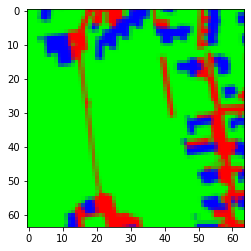

In [21]:
plt.imshow(img.permute(1,2,0));

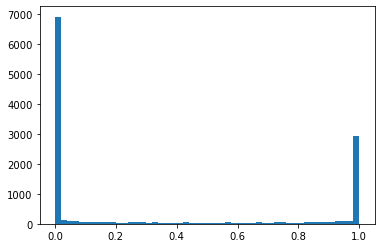

In [23]:
plt.hist(img.detach().cpu().flatten().tolist(), bins = 50);

In [24]:
img.size()
img.sum(axis=1).sum(axis=1)/(image_size**2)

tensor([0.1203, 0.7713, 0.1082])

In [25]:
labels = normalizeRGB(Cad_real_batch[0]).sum(2).sum(2)/(image_size**2)
print(f'label at index i: {labels[i]}')
print(f'label size: {labels.size()}')

label at index i: tensor([0.1203, 0.7713, 0.1082])
label size: torch.Size([64, 3])


In [26]:
c = Condition().to(device)
c.forward(labels = labels.to(device))

tensor([[[[-4.2303e-02]]],


        [[[-2.7270e-02]]],


        [[[-1.4705e-02]]],


        [[[-5.4881e-03]]],


        [[[-5.8283e-03]]],


        [[[ 2.2351e-01]]],


        [[[ 1.2539e-01]]],


        [[[ 4.1035e-01]]],


        [[[ 2.7874e-01]]],


        [[[ 1.0332e-01]]],


        [[[-1.3145e-01]]],


        [[[ 1.5153e-01]]],


        [[[-5.3149e-02]]],


        [[[-5.1687e-02]]],


        [[[-4.5371e-02]]],


        [[[-8.3270e-02]]],


        [[[-9.2297e-02]]],


        [[[ 1.4273e-02]]],


        [[[ 2.0180e-01]]],


        [[[-1.4293e-02]]],


        [[[-6.6369e-02]]],


        [[[ 1.1990e-01]]],


        [[[ 1.3649e-01]]],


        [[[ 4.1897e-02]]],


        [[[-3.0289e-02]]],


        [[[-1.2556e-02]]],


        [[[ 6.2710e-02]]],


        [[[-1.1842e-01]]],


        [[[-4.1198e-02]]],


        [[[-3.4874e-02]]],


        [[[ 4.1933e-01]]],


        [[[-6.3497e-02]]],


        [[[ 1.0126e-02]]],


        [[[ 1.7531e-01]]],


        [[[-1.

## 4.3 Discriminator Architecture

In [40]:
class CondDis(nn.Module):
    def __init__(self, num_conv_layers:int): #, labels: list[float]):
        """
        This is the discriminator class for the conditional discriminator
        Params
        num_conv_layers: number of convolutional layers, domain from 3 to 6
        labels: list of 3 float with the frequency of each entity building, roads, other 
        The output is a tensor with a critic on each image
        
        """
        super(CondDis, self).__init__()
        self.ngpu = torch.cuda.device_count()
        self.device = torch.device("cuda:0" if (torch.cuda.is_available() and self.ngpu > 0) else "cpu")
        self.num_filters = [2**(i+6) for i in range(num_conv_layers-1)]
        self.num_filters.append(1)
        self.num_conv_layers = num_conv_layers
        self.strides = []
        self.paddings = []
        self.kernelSizes = []
        self.numberChannels = 3 # could be an input, 3 are the RGB channels
        self.out_size = []
        self.input_size = 64 # resolution of the image size
        self. num_conv_layers = num_conv_layers
        if self.num_conv_layers == 3:
            # solution 3: {'ins': [64, 22.0, 7.0], 'outs': [22.0, 7.0, 1.0], 'kernel_sizes': [3, 4, 7], 'paddings': [1, 0, 0], 'strides': [3, 3, 3]}
            s3, c3 = conv_path_search(64, kernel_sizes = [3,4,5,7], strides = list(range(1,4)), paddings = [0,1], convs = 3)
            solution = s3[-1] 
            self.strides = solution['strides']
            self.paddings = solution['paddings']
            self.kernelSizes = solution['kernel_sizes']
        if self.num_conv_layers == 4:
            # solution 2: {'ins': [64, 31.0, 14.0, 4.0], 'outs': [31.0, 14.0, 4.0, 1.0], 'kernel_sizes': [4, 5, 5, 4], 'paddings': [0, 0, 0, 0], 'strides': [2, 2, 3, 3]}
            s4, c4 = conv_path_search(64, kernel_sizes = [3,4,5], strides = list(range(2,4)), paddings = [0], convs = 4)
            solution = s4[-1] 
            self.strides = solution['strides']
            self.paddings = solution['paddings']
            self.kernelSizes = solution['kernel_sizes']

        self.main = nn.Sequential(
            # input is (nc) x 64 x 64 -> output nc = 2**6 x 32 x 32
            nn.Conv2d(in_channels=self.numberChannels, 
                      out_channels=self.num_filters[0], 
                      kernel_size=self.kernelSizes[0], 
                      stride=self.strides[0], 
                      padding=self.paddings[0], 
                      bias=False), # (64-4+2)/2 + 1=32
            nn.LeakyReLU(0.2, inplace=True))
        for i in range(1, num_conv_layers):
            # input is nc=(2**(i+5) x 32 x 32 -> output nc = 2**(i+6) x 32*2**(-i) x 32*2**(-i)
            self.main.add_module(str(3*i-1)+"): Conv_"+str(i+1), nn.Conv2d(in_channels=self.num_filters[i-1],
                                                            out_channels=self.num_filters[i],
                                                            kernel_size=self.kernelSizes[i],
                                                            stride=self.strides[i],
                                                            padding=self.paddings[i],
                                                            bias=False))
            if i + 1 < num_conv_layers: 
                self.main.add_module(str(3*i)+"): BatchNorm_" + str(i+1), nn.BatchNorm2d(self.num_filters[i]))
                self.main.add_module(str(1+3*i)+"): LeakyReLU_" + str(i+1), nn.LeakyReLU(negative_slope=0.2, inplace=True))
        
        self.cond = nn.Sequential(
            Condition(num_conv_layers=self.num_conv_layers) #, Reshape(16, 7, 7)
        )
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.num_filters[-1], self.num_filters[-1]),
            nn.BatchNorm1d(self.num_filters[-1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(self.num_filters[-1], 1)
        )
        
    # adding class inputs
    ## def regularize(self, x: float, threshold: float = 0.75):
    ##     '''
    ##     regularize the value of the input x to one of the three standard values 0, 1.5 and 3
    ##     dimgray = 41.18%
    ##     '''
    ##     if x <= threshold:
    ##         x = 0
    ##     elif x >= 3 - threshold:
    ##         x = 1
    ##     else:
    ##         x = 0.4118
    ##     return x
    ## 
    ## def getCadastralLabels(self, img: torch.Tensor):
    ##     '''
    ##     get the labels (number of pixels) for a single image
    ##     '''
    ##     img = normalizeRGB(img)
    ##     intensity = img.sum(axis=0)
    ##     intensity.apply_(self.regularize) # values converge to pre-defined domain
    ##     black = torch.sum(intensity == 0)
    ##     grey = torch.sum(intensity == 0.4118)
    ##     white = torch.sum(intensity == 1)
    ##     return torch.tensor([black, grey, white]).float()
    ## 
    ## def get_batch_cadastral_labels(self, batch: torch.Tensor):
    ##     '''
    ##     returns a batch of cadastral labels (number of pixels) for real images in a batch
    ##     '''
    ##     res = torch.stack([
    ##             self.getCadastralLabels(x_i.detach().cpu()) for i, x_i in enumerate(torch.unbind(batch, dim=0) , 0)
    ##     ], dim=0) 
    ##     return res
    ##     
    ##     # NO ACTIVATION FUNCTION AT THE END: the idea is that the output domain for D is richer and can give a richer critict
    ##     # avoiding local minima for G
    ##     
    ##     # self.main.add_module(str(3*i)+"): Sigmoid", nn.Sigmoid()) 
    ##     # self.main.add_module(str(3*i)+"): Tanh", nn.tanh()) #  or nothing
    
    def forward(self, x):
        # for this operation it is not required to backpropate, therefore it's
        # wrapped in torch.no_grad. Otherwise it gets the error
        # RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.
        with torch.no_grad():
            real_labels = normalizeRGB(x).sum(2).sum(2)/(self.input_size**2)
        # real_labels = self.get_batch_cadastral_labels(x)
        c = self.cond(real_labels.to(self.device))
        x = self.main(x)
        x = self.fc(x + c)
        return x

In [41]:
netD = CondDis(num_conv_layers=3).to(device)
netD.apply(weights_init)
print(netD)

CondDis(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv_2): Conv2d(64, 128, kernel_size=(4, 4), stride=(3, 3), bias=False)
    (3): BatchNorm_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU_2): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv_3): Conv2d(128, 1, kernel_size=(7, 7), stride=(3, 3), bias=False)
  )
  (cond): Sequential(
    (0): Condition(
      (fc): Sequential(
        (0): Linear(in_features=3, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Linear(in_features=512, out_features=1, bias=True)
        (3): LeakyReLU(negative_slope=0.2)
      )
    )
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1, out_features=1, bias=True)
    (2): BatchNorm1d(1, e

In [29]:
netD.forward(Cad_real_batch[0].to(device))

tensor([[ 0.2398],
        [-0.1519],
        [-0.8059],
        [ 0.2374],
        [ 0.3390],
        [-1.4032],
        [ 0.1752],
        [ 0.3351],
        [ 0.4365],
        [ 0.2731],
        [ 0.4703],
        [-0.8427],
        [-0.0978],
        [-0.5404],
        [-0.5720],
        [ 0.3401],
        [-0.5225],
        [-0.2260],
        [-0.4144],
        [ 0.2858],
        [-0.2272],
        [ 0.2220],
        [-0.0080],
        [-0.4236],
        [ 0.4497],
        [-0.4004],
        [-0.3942],
        [ 0.0795],
        [ 0.4446],
        [ 0.1920],
        [ 0.0357],
        [ 0.3111],
        [ 0.4392],
        [-0.0288],
        [-0.7397],
        [ 0.5457],
        [ 0.2995],
        [ 0.3390],
        [ 0.0908],
        [ 0.1738],
        [ 0.4802],
        [ 0.3625],
        [-0.1262],
        [-0.5698],
        [ 0.7040],
        [-0.8320],
        [-1.1884],
        [-0.4759],
        [ 0.3673],
        [ 0.5170],
        [ 0.2689],
        [-0.1405],
        [ 0.

In [30]:
netD.forward(pred.to(device))

tensor([[ 0.2934],
        [ 0.0785],
        [ 0.5445],
        [ 0.3606],
        [ 0.2788],
        [ 0.4000],
        [-0.1088],
        [ 0.3990],
        [ 0.4136],
        [-0.1997],
        [ 0.0544],
        [ 0.6397],
        [ 0.4052],
        [-0.8412],
        [ 0.1827],
        [ 0.3738],
        [-0.4015],
        [-0.3939],
        [ 0.3284],
        [ 0.2465],
        [-0.4375],
        [ 0.2440],
        [-0.1120],
        [-0.1829],
        [-1.2038],
        [ 0.2891],
        [-0.7093],
        [ 0.2959],
        [ 0.2930],
        [ 0.3032],
        [-0.3106],
        [ 0.4269],
        [ 0.3146],
        [-0.0948],
        [-0.4041],
        [-1.3222],
        [ 0.5498],
        [ 0.3160],
        [-1.6321],
        [-0.3075],
        [-0.6575],
        [ 0.5579],
        [ 0.1602],
        [-0.7536],
        [-1.0168],
        [ 0.4234],
        [ 0.0630],
        [ 0.4495],
        [ 0.4367],
        [ 0.2820],
        [ 0.2900],
        [ 0.2865],
        [ 0.

# 5. Training

In [82]:
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
fixed_labels = torch.rand([64, 3]).to(device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# lists for reporting
img_list = []
G_losses = []
D_losses = []

# seeds for torch and numpy
torch.manual_seed(23)
np.random.seed(23)

In [84]:
def trainModel(netG, netD, device, dataloader, optimizerG, optimizerD, epochs, nz, fixed_noise, folder, alternative = False):
    img_list = []
    isDLearning = False
    for epoch in range(epochs):
        if (epoch + 1) % 50 == 0 and alternative:
            if isDLearning:
                isDLearning = False
            else:
                isDLearning = True
        for i, data in enumerate(dataloader, 0):
            # 0 Load data
            xr = data[0].to(device)
            b_size = xr.size(0)
            z = torch.randn(b_size, nz, 1, 1).to(device)
            l = torch.rand([b_size, 3]).to(device)
            
            # 1 Train D
            if not alternative or isDLearning or epoch == 0:
                netD.zero_grad()

                # 1.1 train on real data
                # print('1.1 - Train D: real data')
                predr = netD(xr).view(-1)
                # maximize predr, therefore minus sign
                lossr = -predr.mean() # to be minimized in the optimization, therefore -inf is the goal

                # 1.2 train on fake data
                # print('1.2 - Train D: fake data')
                xf = netG(z, l).detach()  # without .detach() gradient would be passed down
                predf = netD(xf)
                # calculate loss: minimize predf
                lossf = predf.mean()

                # 1.3 gradient penalty
                # print('1.3 - Calulate loss and backpropagate')
                gp = 0.2 * gradient_penalty(netD, xr, xf) # lambda gradient penalty = 0.2
                # aggregate all
                loss_D = lossr + lossf + gp # lambda_gradient_penality * gp 
                loss_D.backward()
                optimizerD.step()
            
            # 2. train G
            if not alternative or not isDLearning:
                # print('2 - Train G')
                netG.zero_grad()
                xf = netG(z, l)
                predf = netD(xf.to(device))
                # print('2 - Train G: calculate loss and backpropagate')
                # maximize predf.mean()
                loss_G = -predf.mean() # to be minimized in the optimization, therefore -1 is the goal
                loss_G.backward()
                optimizerG.step()
            # Save Losses for plotting later
            # G_losses.append(loss_G.item())
            # D_losses.append(loss_D.item())
        if epoch % 1 == 0:
            print(f'Epoch: {epoch}/{epochs} | D Loss: {np.round(loss_D.item(), 4)}' + 
                  f'| ErrDReal: {np.round(lossr.item(), 4)} | ErrDFake: {np.round(lossf.item(), 4)} ' + 
                  f'| GradPenality: {np.round(gp.item(), 4)} | G Loss: {np.round(loss_G.item(), 4)}')
        if epoch % 10 == 0:
            # Generate and save fake images to monitor the progress
            with torch.no_grad():
                fake = netG(fixed_noise, fixed_labels).detach().cpu()
                i = random.sample(range(b_size), 1)[0]
                if epoch < 10:
                    epoch = '000' + str(epoch)
                elif epoch < 100:
                    epoch = '00' + str(epoch)
                elif epoch < 1000:
                    epoch = '0' + str(epoch)
                path = folder + 'reports/CGANBestImages/CGANProgress_Epoch' + str(epoch) + '.png'
                fake_grid = vutils.make_grid(fake, padding=2, normalize=True)
                vutils.save_image(fake_grid, path)
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
    return (img_list)

In [85]:
%%time
imgs = trainModel(netG = netG, netD = netD, device = device, dataloader = Cad_dataloader, 
           optimizerG = optimizerG, optimizerD = optimizerD, epochs = 500, 
           nz = nz, fixed_noise = fixed_noise, folder = '../', alternative=True)

Epoch: 0/500 | D Loss: 0.0818| ErrDReal: -1.334 | ErrDFake: 1.222 | GradPenality: 0.1938 | G Loss: -1.2455
Epoch: 1/500 | D Loss: 0.0818| ErrDReal: -1.334 | ErrDFake: 1.222 | GradPenality: 0.1938 | G Loss: -1.2324
Epoch: 2/500 | D Loss: 0.0818| ErrDReal: -1.334 | ErrDFake: 1.222 | GradPenality: 0.1938 | G Loss: -1.2361
Epoch: 3/500 | D Loss: 0.0818| ErrDReal: -1.334 | ErrDFake: 1.222 | GradPenality: 0.1938 | G Loss: -1.2359
Epoch: 4/500 | D Loss: 0.0818| ErrDReal: -1.334 | ErrDFake: 1.222 | GradPenality: 0.1938 | G Loss: -1.2367
Epoch: 5/500 | D Loss: 0.0818| ErrDReal: -1.334 | ErrDFake: 1.222 | GradPenality: 0.1938 | G Loss: -1.2423
Epoch: 6/500 | D Loss: 0.0818| ErrDReal: -1.334 | ErrDFake: 1.222 | GradPenality: 0.1938 | G Loss: -1.2183
Epoch: 7/500 | D Loss: 0.0818| ErrDReal: -1.334 | ErrDFake: 1.222 | GradPenality: 0.1938 | G Loss: -1.2508
Epoch: 8/500 | D Loss: 0.0818| ErrDReal: -1.334 | ErrDFake: 1.222 | GradPenality: 0.1938 | G Loss: -1.2542
Epoch: 9/500 | D Loss: 0.0818| ErrDRe

In [86]:
netG(fixed_noise, fixed_labels).detach().cpu()

tensor([[[[0.0168, 0.0170, 0.0178,  ..., 0.0147, 0.0154, 0.0157],
          [0.0162, 0.0170, 0.0175,  ..., 0.0149, 0.0156, 0.0157],
          [0.0176, 0.0163, 0.0186,  ..., 0.0149, 0.0154, 0.0150],
          ...,
          [0.0149, 0.0152, 0.0126,  ..., 0.0167, 0.0158, 0.0176],
          [0.0152, 0.0156, 0.0154,  ..., 0.0166, 0.0166, 0.0157],
          [0.0158, 0.0160, 0.0141,  ..., 0.0180, 0.0162, 0.0166]],

         [[0.0165, 0.0183, 0.0181,  ..., 0.0142, 0.0155, 0.0158],
          [0.0171, 0.0182, 0.0175,  ..., 0.0152, 0.0157, 0.0159],
          [0.0172, 0.0191, 0.0158,  ..., 0.0160, 0.0151, 0.0153],
          ...,
          [0.0143, 0.0169, 0.0126,  ..., 0.0190, 0.0179, 0.0183],
          [0.0149, 0.0168, 0.0142,  ..., 0.0183, 0.0160, 0.0161],
          [0.0152, 0.0153, 0.0154,  ..., 0.0185, 0.0168, 0.0169]],

         [[0.0170, 0.0179, 0.0182,  ..., 0.0142, 0.0158, 0.0157],
          [0.0159, 0.0164, 0.0167,  ..., 0.0148, 0.0153, 0.0158],
          [0.0173, 0.0175, 0.0182,  ..., 0

## 5.1 Hyperparameter Tuning

In [104]:
%%time
run_tag = datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%S")

experiment_id = mlflow.create_experiment(
    f"../reports/CGAN_Exp_{run_tag}",
    tags={"version": "v1", "priority": "P1"},
)

mlflow.set_experiment(experiment_id=experiment_id)
study = optuna.create_study(study_name=f"CGAN_study_{run_tag}", direction="minimize")

# Wrap the objective inside a lambda and call objective inside it
func = lambda trial: objective(trial, nz, Cad_dataloader, n_epochs = 10, folder = '../',
                              experiment='CGAN_Cadastral_')

study.optimize(func, n_trials=1)

[I 2023-06-04 17:00:05,073] A new study created in memory with name: CGAN_study_2023-06-04T17:00:05


Convolutions for D: 5 | Convolutions for G: 6 | LrRate: 0.0001 | Dropout G: 0.2
Epoch: 0/10 | D Loss: -32.8631| ErrDReal: -16.0399 | ErrDFake: -16.9891 | GradPenality: 0.1659 | G Loss: 23.3137
Epoch: 1/10 | D Loss: -115.8232| ErrDReal: -59.8422 | ErrDFake: -56.1251 | GradPenality: 0.144 | G Loss: 59.4303
Epoch: 2/10 | D Loss: -179.4722| ErrDReal: -92.1263 | ErrDFake: -87.5131 | GradPenality: 0.1672 | G Loss: 86.1145
Epoch: 3/10 | D Loss: -236.0518| ErrDReal: -122.0336 | ErrDFake: -114.2032 | GradPenality: 0.185 | G Loss: 119.4082
Epoch: 4/10 | D Loss: -261.909| ErrDReal: -122.2397 | ErrDFake: -139.8528 | GradPenality: 0.1835 | G Loss: 131.0236
Epoch: 5/10 | D Loss: -348.7874| ErrDReal: -179.1198 | ErrDFake: -169.8465 | GradPenality: 0.1789 | G Loss: 180.4006
Epoch: 6/10 | D Loss: -331.6691| ErrDReal: -134.6615 | ErrDFake: -197.1914 | GradPenality: 0.1838 | G Loss: 174.0817
Epoch: 7/10 | D Loss: -478.5762| ErrDReal: -249.843 | ErrDFake: -228.89 | GradPenality: 0.1569 | G Loss: 243.0359


[I 2023-06-04 17:08:21,595] Trial 0 finished with value: 0.6815868020057678 and parameters: {'lr': 0.00012436110136462071, 'dropoutG': 0.2, 'convsG': 6, 'convsD': 5}. Best is trial 0 with value: 0.6815868020057678.


CPU times: user 33.6 s, sys: 2.08 s, total: 35.6 s
Wall time: 8min 16s


# Again Expertiment on Conv2d Params
gettin a system behind the relation between the number of layers and the kernel size, given a fix padding, stride input and output size

$o=\frac{i-k+2p}{s} + 1$

$i=(o - 1)s + k - 2p$
<p>
    where:
<li>o = output
<li>i = input
<li>k = kernel size
<li>s = stride
<p>

$k=  i + 2p - s*(o + 1)$
<p>
    where:
<li>o = output
<li>i = input
<li>k = kernel size
<li>s = stride
<p>

#### Implementation of a grid search with 3 dimensions, k, s, p

In [37]:
def single_conv(ins: int, kernel_size: int, stride: int = 2, padding: int = 1):
    ''' 
    returns the size of the output after a single convolution given 
    input size, kernel size, stride and padding.
    The operations returns the output size of one dimension (or both dimensions)
    given a quadratic pic and same params for horizontal and vertical processing
    '''
    out = ((ins + 2 * padding - kernel_size) / stride) + 1
    return out

def conv_grid_search(ins: int, kernel_sizes: list[int], strides: list[int], paddings: list[int]):
    '''
    returns all the viable combinations that return entire outputs given a precise input size 
    and list of possible strides, paddings and kernel sizes
    '''
    results = []
    for k in kernel_sizes:
        for p in paddings:
            for s in strides:
                out = single_conv(ins = ins, kernel_size=k, stride = s, padding = p)
                if out.is_integer():
                    result = {'ins': [ins], 'outs': [out], 'kernel_sizes': [k], 'paddings': [p], 'strides': [s]}
                    results.append(result)
    return results

def conv_path_search(ins: int, kernel_sizes: list[int], strides: list[int], paddings: list[int], convs: int = 3, out: int = 1):
    '''
    This function returns possible convolution paths to return a vector with dimensions filter, 1, 1
    '''
    solutions = []
    # 
    # results = {'ins': [ins], 'outs': [], 'kernel_sizes': [], 'paddings': [], 'strides': []}
    # candidates = {'ins': [ins], 'outs': [], 'kernel_sizes': [], 'paddings': [], 'strides': []}
    candidates = conv_grid_search(ins, kernel_sizes, strides, paddings)
    for conv in range(convs - 1):
        new_candidate_list = []
        for c in candidates:
            # print(f"candidate: {c}")
            new_ins = c['outs'][-1]
            new_candidates = conv_grid_search(new_ins, kernel_sizes, strides, paddings)
            # print(f"new candidates: {new_candidates}")
            for new in new_candidates:
                # thread = dict(c)
                thread = copy.deepcopy(c)
                # print(f"thread: {thread}")
                thread['ins'].append(new['ins'][0])
                thread['outs'].append(new['outs'][0])
                thread['kernel_sizes'].append(new['kernel_sizes'][0])
                thread['paddings'].append(new['paddings'][0])
                thread['strides'].append(new['strides'][0])
                new_candidate_list.append(thread)
                # print(f'c: {c}')
            candidates.remove(c)
        # print(f"new candidates list: {new_candidate_list}")
        candidates = new_candidate_list[:]
        # print(f"candidates: {candidates}")
        # print(f"candidates: {candidates}")
    for cand in candidates:
        # condition 1: returns dimension 1
        if cand['outs'][-1] == out:
            # condition 2: kernel size larger or equal to stride
            isStrideSmallerKernel = True
            # condition 3: decreasing dimension of the kernel
            isKernelDecreasging = True
            # condition 4: decreasing stride
            isStrideDecreasing = True
            for i in range(len(cand['strides'])):
                if cand['strides'][i] > cand['kernel_sizes'][i]:
                    isStrideSmallerKernel = False
                if i > 0:
                    if cand['kernel_sizes'][i] > cand['kernel_sizes'][i - 1]:
                        isKernelDecreasging = False
                    if cand['strides'][i] > cand['strides'][i - 1]:
                        isStrideDecreasing = False
            if isStrideSmallerKernel and isKernelDecreasging and isStrideDecreasing:
                solutions.append(cand)
    return solutions, candidates
    

def find_kernel_size(ins: int, outs: int, stride: int, padding:int, kernel_size:int, verbose:bool = False):
    '''
    returns the size of the kernel of a convolution, given that the output must be a whole number
    the kernel size is increased progressively adding 2 units, so that the dimension is kept uneven.
    If the kernel size is larger than the input size, then the function retuns None
    '''
    guessed_outs = single_conv(ins = ins, kernel_size=kernel_size, stride = stride, padding = padding)
    largest = max(ins, outs) # convolution or transposed convolution
    # while not guessed_outs.is_integer():
    while guessed_outs != outs:
        kernel_size += 2
        guessed_outs = single_conv(ins = ins, kernel_size=kernel_size, stride = stride, padding = padding)
        if kernel_size > largest:
            if verbose:
                print (f'convolution not possible with these params -> input: {ins} | output: {outs} | kernel_size: {kernel_size} | stride: {stride} | padding: {padding}')
            return None
    if verbose:
        print(f'kernel size for a convolution with input dimension: {ins}, output: {outs}, stride: {stride}, padding: {padding}, is equal to {kernel_size}')
    return kernel_size

def change_convolution_params(ins: int, outs: int, stride: int, padding:int, kernel_size:int, verbose = False):
    '''
    returns params of a convolution given an input and an output size. 
    stride, padding and kernel size are variables. 
    First kernel size is modified with the function find_kernel_size, then the padding is redued.
    If no solution is possible, the kernel size returns to the initial input and the stride is increased
    and passed to the function find_kernel_size.
    '''
    largest = max(ins, outs)
    res_kernel_size = find_kernel_size(ins = ins, outs = outs, stride = stride, padding = padding, kernel_size=kernel_size)
    while res_kernel_size is None:
        if padding >= 1:
            padding -= 1
            res_kernel_size = find_kernel_size(ins = ins, outs = outs, stride = stride, padding = padding, kernel_size=kernel_size)
        else:
            stride += 1
            res_kernel_size = find_kernel_size(ins = ins, outs = outs, stride = stride, padding = padding, kernel_size=kernel_size)
            if stride > largest:
                print(f'solution not found with the parameters: input: {ins} | output: {outs} | kernel_size: {kernel_size} | stride: {stride} | padding: {padding}')
                return None
    solution = {"ins": ins, "outs": outs, "stride": stride, "padding": padding, "kernel_size": res_kernel_size}
    return solution

### 3 Convolutions

In [51]:
s3, c3 = conv_path_search(128, kernel_sizes = [15, 13, 11, 9, 7, 5, 3, 2], strides = list(range(1, 8)), paddings = [0,1], convs = 3)
print(f'solutions with 3 convolutions:')
for i, solution in enumerate(s3):
    print(f'solution {i+1}: {solution}') 

solutions with 3 convolutions:
solution 1: {'ins': [128, 18.0, 2.0], 'outs': [18.0, 2.0, 1.0], 'kernel_sizes': [11, 11, 2], 'paddings': [1, 0, 0], 'strides': [7, 7, 1]}
solution 2: {'ins': [128, 18.0, 2.0], 'outs': [18.0, 2.0, 1.0], 'kernel_sizes': [11, 11, 2], 'paddings': [1, 0, 0], 'strides': [7, 7, 2]}


### 4 Convolutions

In [44]:
s4, c4 = conv_path_search(128, kernel_sizes = [2,3,5,7,9,11,13,15], strides = list(range(1,10)), paddings = [0], convs = 4)
print(f'solutions with 4 convolutions:')
for i, solution in enumerate(s4):
    print(f'solution {i+1}: {solution}') 

solutions with 4 convolutions:
solution 1: {'ins': [128, 18.0, 10.0, 2.0], 'outs': [18.0, 10.0, 2.0, 1.0], 'kernel_sizes': [9, 9, 9, 2], 'paddings': [0, 0, 0, 0], 'strides': [7, 1, 1, 1]}
